## Deploying Hugging Face Models into Azure ML Managed Online Endpoint

This notebook demonstrates the process of deploying registered models in Azure ML workspace
to an AZURE ML managed online endpoint for real-time inference.

[Learn more about Azure ML Managed Online Endpoints](https://learn.microsoft.com/en-us/azure/machine-learning/concept-endpoints-online?view=azureml-api-2)

### Prerequisites
- An Azure account with an active subscription. [Create one for free](https://azure.microsoft.com/free/).
- An Azure ML workspace set up. [Learn how to set up a workspace](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-manage-workspace?view=azureml-api-2&tabs=python).
- Install the Azure ML client library for Python with pip.
  ```bash
     pip install azure-ai-ml
     pip install azure-identity
  ```
- Execute the `az login` command to sign in to your Azure subscription. For detailed instructions, refer to the "Authenticate with Azure Subscription" section in the notebook provided [here](../setup/setup_azure.md)
- A Hugging Face model should be present in the AZURE ML model catalog. If it is missing, execute the [notebook](./download_and_register_hf_model_aml.ipynb) to download and register the Hugging Face model in the AZURE ML registry.

### Load Environment Variables

Load necessary environment variables from an `.env` file.

### Environment Variables

For ex., to download the Hugging Face model `cognitivecomputations/Wizard-Vicuna-13B-Uncensored` into your Azure environment, below are the environment variables that needs to be set in `.env` file:

1. **AZURE_SUBSCRIPTION_ID**
   - Obtain your Azure Subscription ID, essential for accessing Azure services.

2. **AZURE_RESOURCE_GROUP**
   - Identify the Resource Group where your Azure Machine Learning (AZURE ML) workspace is located.

3. **AZURE_ML_WORKSPACE_NAME**
   - Specify the name of your AZURE ML workspace where the model will be registered.

4. **AZURE_ML_REGISTRY_NAME**
   - Choose a name for registering the model in your AZURE ML workspace, such as "HuggingFace". This helps in identifying if the model already exists in your AZURE ML Hugging Face registry.

5. **AZURE_ML_MODEL_NAME_TO_DEPLOY**
   - If the model is listed in the AZURE ML Hugging Face model catalog, then supply the model name as shown in the following image. 
   <br> <img src="./../../assets/aml_hf_model.png" alt="aml_hf_model.png" height="400"/> <br>
   - If you intend to deploy the model from the AZURE ML workspace model registry, then use the model name as shown in the subsequent image.
   <br> <img src="./../../assets/aml_ws_model.png" alt="aml_ws_model.png" height="400"/> <br>
6. **AZURE_ML_MODEL_VERSION_TO_DEPLOY**
   - You can find the details of the model version in the images from previous step associated with the respective model.

7. **AZURE_ML_MODEL_DEPLOY_INSTANCE_SIZE**
   - Select the size of the compute instance of for deploying the model, ensuring it's at least double the size of the model to effective inference.

9. **AZURE_ML_MODEL_DEPLOY_INSTANCE_COUNT**
   - Number of compute instances for model deployment.

10. **AZURE_ML_MODEL_DEPLOY_REQUEST_TIMEOUT_MS**
    - Set the AZURE ML inference endpoint request timeout, recommended value is 60000 (in millis).

11. **AZURE_ML_MODEL_DEPLOY_LIVENESS_PROBE_INIT_DELAY_SECS**
    - Configure the liveness probe initial delay value for the Azure ML container hosting your model. The default `initial_delay` value for the liveness probe, as established by Azure ML managed compute, is 600 seconds. Consider raising this value for the deployment of larger models.


In [ ]:

from dotenv import load_dotenv
import os
import random
import string

# Load the environment variables from the .env file
load_dotenv()

subscription_id = os.getenv('AZURE_SUBSCRIPTION_ID')
resource_group = os.getenv('AZURE_RESOURCE_GROUP')
workspace_name = os.getenv('AZURE_ML_WORKSPACE_NAME')
registry_name = os.getenv('AZURE_ML_REGISTRY_NAME')
model_to_deploy = os.getenv('AZURE_ML_MODEL_NAME_TO_DEPLOY')
model_version = os.getenv("AZURE_ML_MODEL_VERSION_TO_DEPLOY")
instance_type = os.getenv('AZURE_ML_MODEL_DEPLOY_INSTANCE_SIZE')
instance_count = int(os.getenv('AZURE_ML_MODEL_DEPLOY_INSTANCE_COUNT'))
request_timeout_ms = int(os.getenv('AZURE_ML_MODEL_DEPLOY_REQUEST_TIMEOUT_MS'))
liveness_probe_initial_delay = int(os.getenv('AZURE_ML_MODEL_DEPLOY_LIVENESS_PROBE_INIT_DELAY_SECS'))

In [ ]:
print(f"Subscription ID: {subscription_id}")
print(f"Resource group: {resource_group}")
print(f"Workspace name: {workspace_name}")
print(f"Registry name: {registry_name}")
print(f"Model to deploy: {model_to_deploy}")
print(f"Model version: {model_version}")
print(f"Instance type: {instance_type}")
print(f"Instance count: {instance_count}")
print(f"Request timeout in millis: {request_timeout_ms}")
print(f"Liveness probe initial delay in secs: {liveness_probe_initial_delay}")

### Configure Credentials

Set up the `DefaultAzureCredential` for seamless authentication with Azure services. This method should handle most authentication scenarios. If you encounter issues, refer to the [Azure Identity documentation](https://docs.microsoft.com/en-us/python/api/azure-identity/azure.identity?view=azure-python) for alternative credentials.


In [ ]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.core.exceptions import ResourceNotFoundError
from typing import Union

try:
    credential: Union[DefaultAzureCredential, InteractiveBrowserCredential] = DefaultAzureCredential()
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    credential = InteractiveBrowserCredential()

workspace_ml_client = MLClient(
    credential,
    subscription_id=subscription_id,
    resource_group_name=resource_group,
    workspace_name=workspace_name
)
registry_ml_client = MLClient(credential, registry_name=registry_name)

In [ ]:
def check_model_version_exists(client, model_name, version) -> bool:
    """
    Checks for the existence of a specific version of a model with the given name in the client registry.

    This function lists all models with the given name in the registry using the provided client. It then checks if the specified version exists among those models.

    Args:
        client: The client object used to interact with the model registry. This can be an Azure ML model catalog client or an Azure ML workspace model client.
        model_name (str): The name of the model to check in the registry.
        version (str): The specific version of the model to check for.

    Returns:
        bool: True if the model with the specified version exists in the registry, False otherwise.
    """
    model_found = False
    try:
        models = list(client.models.list(name=model_name))
        model_found = any(model.version == version for model in models)
    except ResourceNotFoundError as rnfe:
        print(f"Model not found in the registry{registry_name}, please try other registry.")
    return model_found


In [ ]:
# Check if the Hugging Face model exists in the Azure ML workspace model registry
model = None
if check_model_version_exists(workspace_ml_client, model_to_deploy, model_version):
    print("Model found in the Azure ML workspace model registry.")
    model = workspace_ml_client.models.get(model_to_deploy, model_version)
    print(
        "\n\nUsing model name: {0}, version: {1}, id: {2} for inferencing".format(
            model.name, model.version, model.id
        )
    )
# Check if the Hugging Face model exists in the Azure ML model catalog registry
elif check_model_version_exists(registry_ml_client, model_to_deploy, model_version):
    print("Model found in the Azure ML model catalog registry.")
    model = registry_ml_client.models.get(model_to_deploy, model_version)
    print(
        "\n\nUsing model name: {0}, version: {1}, id: {2} for inferencing".format(
            model.name, model.version, model.id
        )
    )
else:
    raise ValueError(f"Model {model_to_deploy} not found in any registry. Please run the notebook (download_and_register_hf_model_aml.ipynb) to download and register Hugging Face model to Azure ML workspace model registry.")
endpoint_name = model_to_deploy + str(model_version)

In [ ]:
def get_updated_endpoint_name(endpoint_name):
    """
    Generates a unique string based on the Azure ML endpoint name.

    This function takes the first 26 characters of the given endpoint name and appends
    a 5-character random alphanumeric string with hypen to ensure uniqueness.
    """
    # Take the first 26 characters of the endpoint name
    base_name = endpoint_name[:26]

    # Generate a 5-char random alphanumeric string and append to '-'
    random_suffix = '-' + ''.join(random.choices(string.ascii_letters + string.digits, k=5))

    updated_name = f"{base_name}{random_suffix}"

    return updated_name


In [ ]:
endpoint_name = get_updated_endpoint_name(endpoint_name)

In [ ]:
print(f"Endpoint name: {endpoint_name}")

**Create an Azure ML managed online endpoint**
To define an endpoint, you need to specify:

Endpoint name: The name of the endpoint. It must be unique in the Azure region. For more information on the naming rules, see managed online endpoint limits.
Authentication mode: The authentication method for the endpoint. Choose between key-based authentication and Azure Machine Learning token-based authentication. A key doesn't expire, but a token does expire. 

In [ ]:
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    OnlineRequestSettings,
    ProbeSettings
)

# create an online endpoint
endpoint = ManagedOnlineEndpoint(name=endpoint_name, description=f"Online endpoint for {model_to_deploy}", auth_mode="key")
workspace_ml_client.begin_create_or_update(endpoint).wait()

**Add deployment to an Azure ML endpoint created above**

Please be aware that deploying, particularly larger models, may take some time. Once the deployment is finished, the provisioning state will be marked as 'Succeeded', as illustrated in the image below.
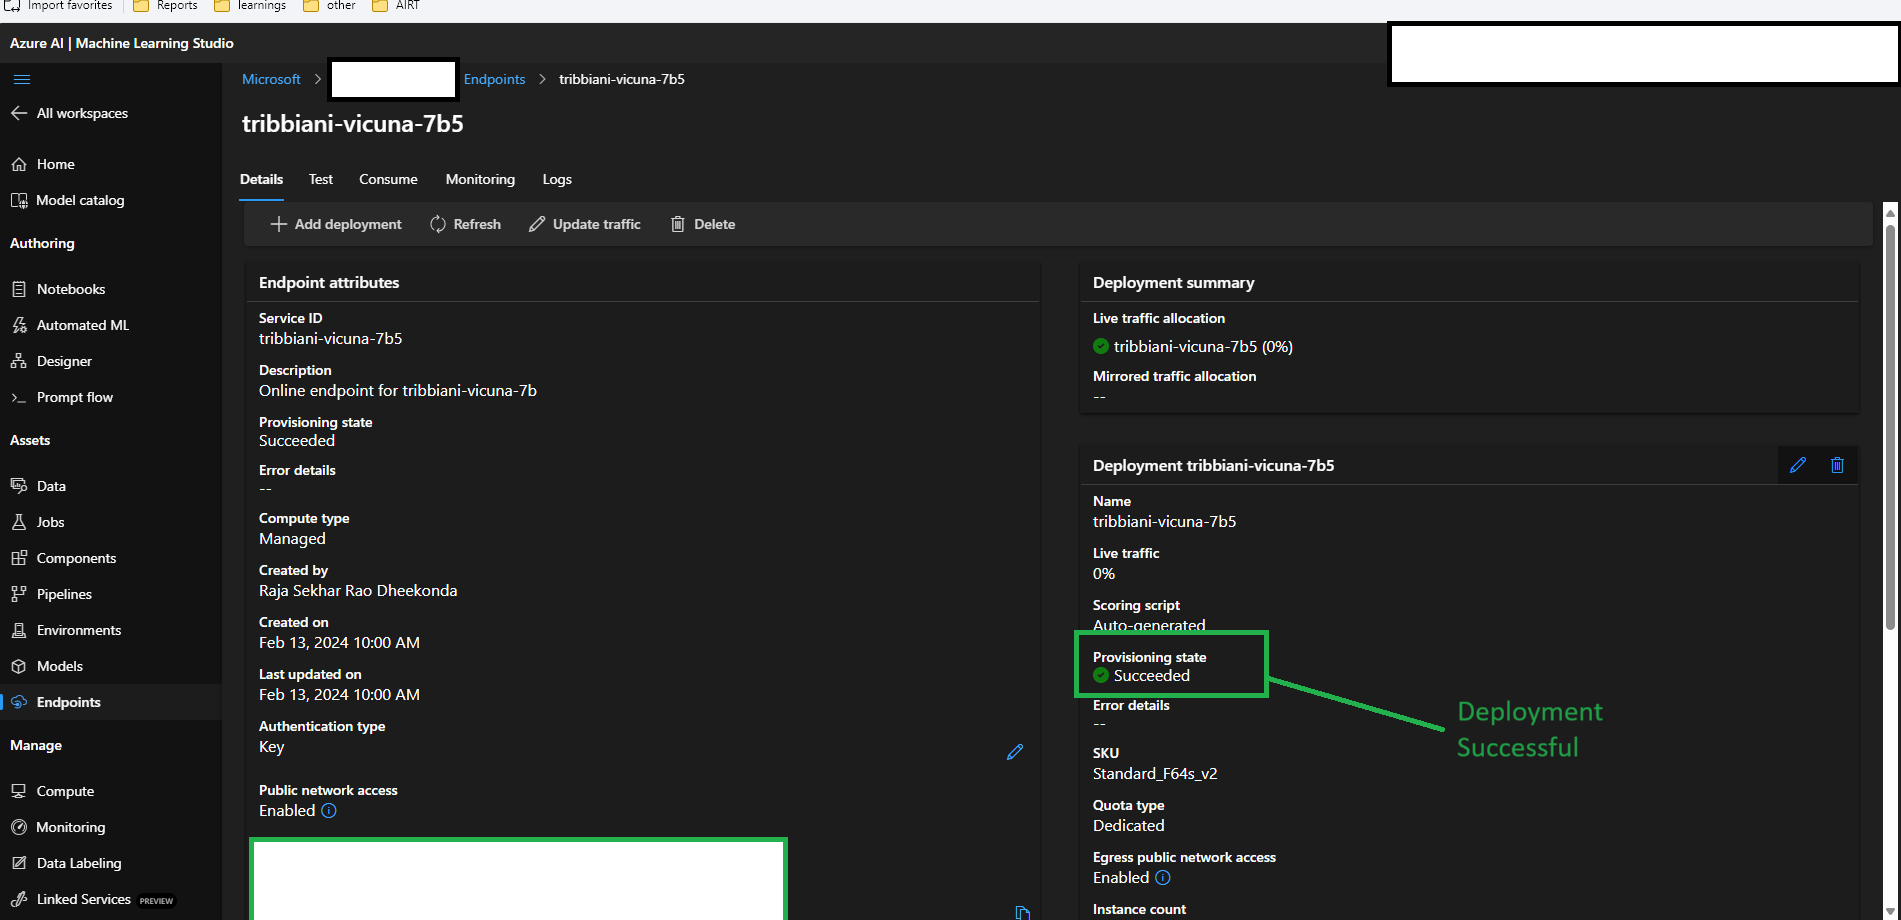
<br> <img src="./../../assets/aml_endpoint_deployment.png" alt="aml_endpoint_deployment.png" height="400"/> <br>

In [ ]:
# create a deployment
# Create probe settings
liveness_probe = ProbeSettings(initial_delay=liveness_probe_initial_delay)
deployment = ManagedOnlineDeployment(
    name=f"{endpoint_name}",
    endpoint_name=endpoint_name,
    model=model.id,
    instance_type=instance_type,
    instance_count=instance_count,
    request_settings=OnlineRequestSettings(
        request_timeout_ms=request_timeout_ms
    ),
    liveness_probe=liveness_probe
)
workspace_ml_client.online_deployments.begin_create_or_update(deployment).wait()
workspace_ml_client.begin_create_or_update(endpoint).result()